In [28]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen
import snntorch.utils
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
# falls nötig: !pip install snntorch

In [29]:
time_steps = 100
num_inputs = 100
num_interneurons = 50
num_msns = 20
batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_rates = torch.rand(batch_size, num_inputs) * 0.9 + 0.1
input_data = torch.zeros(batch_size, num_inputs, time_steps)
for b in range(batch_size):
    for n in range(num_inputs):
        intervals = torch.exp(torch.rand(time_steps) * -lambda_rates[b, n])
        cumulative_time = torch.cumsum(intervals, dim=0) * time_steps
        spike_times = torch.floor(cumulative_time).long() % time_steps
        unique_spike_times, counts = torch.unique(spike_times, return_counts=True)
        input_data[b, n, unique_spike_times] = 1.0
input_data = input_data.to(device)

class NAccNetwork(nn.Module):
    def __init__(self, num_inputs, num_interneurons, num_msns):
        super(NAccNetwork, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_interneurons)
        self.fc2 = nn.Linear(num_interneurons, num_msns)
        self.fc3 = nn.Linear(num_inputs, num_msns)
        self.spike_fn = snn.Leaky(beta=0.9, threshold=1.0, reset_mechanism="zero")

    def forward(self, x):
        h1 = self.fc1(x)
        spk1, mem1 = self.spike_fn(h1)
        h2 = self.fc2(spk1) * -1
        spk2, mem2 = self.spike_fn(h2)
        h3 = self.fc3(x)
        spk3, mem3 = self.spike_fn(h3)
        msn_input = h2 + h3
        spk_output, mem_output = self.spike_fn(msn_input)
        return spk1, spk2, spk_output

net = NAccNetwork(num_inputs, num_interneurons, num_msns).to(device)

In [30]:
spike_record_input = []
spike_record_interneurons = []
spike_record_msns = []

snn.utils.reset(net)

for t in range(time_steps):
    input_t = input_data[:, :, t]
    spk1, spk2, spk_output = net(input_t)
    spike_record_input.append(input_t.cpu().detach().numpy())
    spike_record_interneurons.append(spk1.cpu().detach().numpy())
    spike_record_msns.append(spk_output.cpu().detach().numpy())

spike_record_input = np.array(spike_record_input).squeeze()
spike_record_interneurons = np.array(spike_record_interneurons).squeeze()
spike_record_msns = np.array(spike_record_msns).squeeze()

print("Summe der Input-Spikes:", np.sum(spike_record_input))
print("Summe der Interneuron-Spikes:", np.sum(spike_record_interneurons))
print("Summe der MSN-Spikes:", np.sum(spike_record_msns))

Summe der Input-Spikes: 6414.0
Summe der Interneuron-Spikes: 175.0
Summe der MSN-Spikes: 306.0


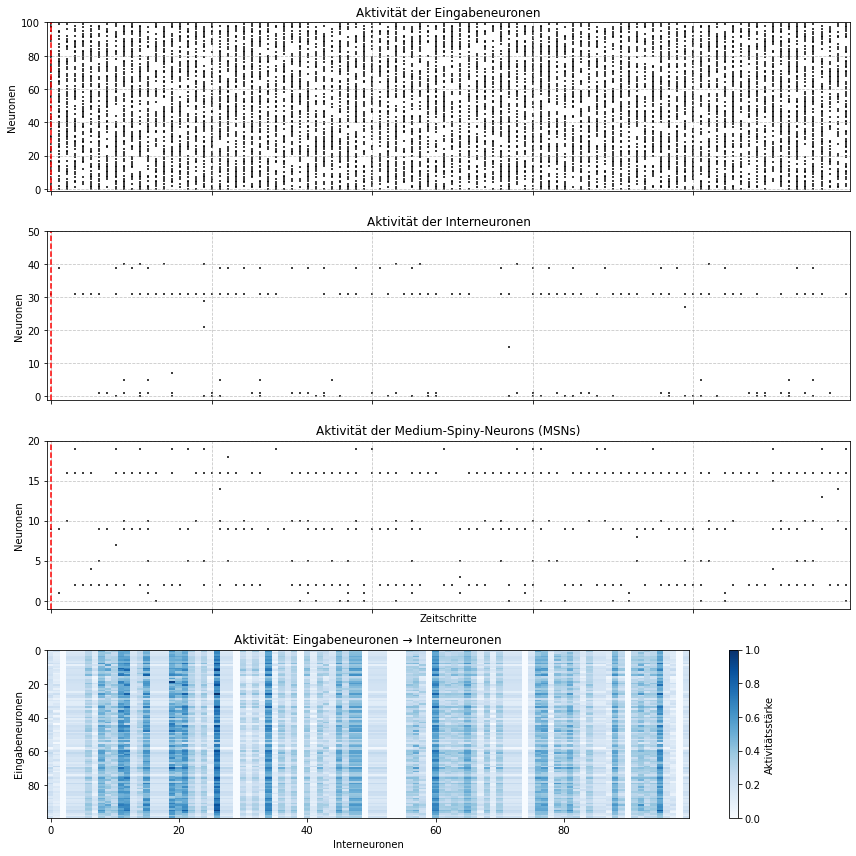

In [32]:
# calc activity of input to inter neurons
net = net.to('cpu')
weights_fc1 = net.fc1.weight.detach().numpy()
input_spikes = spike_record_input.T
inter_spikes = spike_record_interneurons.T

# spike activity through time
activity_input_to_inter = np.dot(weights_fc1, input_spikes)
activity_input_to_inter = np.dot(activity_input_to_inter.T, inter_spikes)
activity_input_to_inter = np.abs(activity_input_to_inter)

threshold = 0.1
activity_input_to_inter[activity_input_to_inter < threshold] = 0
activity_input_to_inter = activity_input_to_inter / np.max(activity_input_to_inter)

fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

def plot_input_activity():
    axs[0].clear()
    for neuron in range(num_inputs):
        spike_times = np.where(spike_record_input[:, neuron])[0]
        axs[0].scatter(spike_times, np.ones_like(spike_times) * neuron, s=5, c='black', marker='|')
    axs[0].set_title("Aktivität der Eingabeneuronen")
    axs[0].set_ylabel("Neuronen")
    axs[0].set_ylim(-1, num_inputs)
    axs[0].grid(True, linestyle='--', alpha=0.7)

def plot_interneuron_activity():
    axs[1].clear()
    for neuron in range(num_interneurons):
        spike_times = np.where(spike_record_interneurons[:, neuron])[0]
        axs[1].scatter(spike_times, np.ones_like(spike_times) * neuron, s=5, c='black', marker='|')
    axs[1].set_title("Aktivität der Interneuronen")
    axs[1].set_ylabel("Neuronen")
    axs[1].set_ylim(-1, num_interneurons)
    axs[1].grid(True, linestyle='--', alpha=0.7)

def plot_msn_activity():
    axs[2].clear()
    for neuron in range(num_msns):
        spike_times = np.where(spike_record_msns[:, neuron])[0]
        axs[2].scatter(spike_times, np.ones_like(spike_times) * neuron, s=5, c='black', marker='|')
    axs[2].set_title("Aktivität der Medium-Spiny-Neurons (MSNs)")
    axs[2].set_ylabel("Neuronen")
    axs[2].set_xlabel("Zeitschritte")
    axs[2].set_ylim(-1, num_msns)
    axs[2].grid(True, linestyle='--', alpha=0.7)

def plot_input_to_inter_activity():
    axs[3].clear()
    im = axs[3].imshow(activity_input_to_inter, aspect="auto", cmap="Blues", interpolation="nearest", vmin=0, vmax=1)
    axs[3].set_title("Aktivität: Eingabeneuronen → Interneuronen")
    axs[3].set_ylabel("Eingabeneuronen")
    axs[3].set_xlabel("Interneuronen")
    plt.colorbar(im, ax=axs[3], label="Aktivitätsstärke")

plot_input_activity()
plot_interneuron_activity()
plot_msn_activity()
plot_input_to_inter_activity()

line_input = axs[0].axvline(x=0, color='red', linestyle='--')
line_inter = axs[1].axvline(x=0, color='red', linestyle='--')
line_msn = axs[2].axvline(x=0, color='red', linestyle='--')

def update(frame):
    line_input.set_xdata([frame, frame])
    line_inter.set_xdata([frame, frame])
    line_msn.set_xdata([frame, frame])
    return line_input, line_inter, line_msn

ani = FuncAnimation(fig, update, frames=time_steps, interval=100, blit=True)
plt.tight_layout()
plt.show()